In [17]:
import glob
import os
import torch
import torchaudio

AUDIO_PATH = "audio_data"
SAMPLE_RATE = 48000
file_paths = glob.glob(os.path.join(AUDIO_PATH, "**", "*.wav"), recursive=True)
EMOTIONS_MAP = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgust",
    7: "surprised",
}

In [18]:
train_files, val_files, test_files = file_paths[:int(len(file_paths)*0.8)], file_paths[int(len(file_paths)*0.8):int(len(file_paths)*0.9)], file_paths[int(len(file_paths)*0.9):]

In [19]:
def add_awgn(signal: torch.Tensor, snr_low=15, snr_high=30):
    signal_len = signal.size(1)
    num_channels = signal.size(0)

    noise = torch.randn(num_channels, signal_len, dtype=torch.float32)

    norm_constant = 2.0 ** (16 - 1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant

    s_power = torch.sum(signal_norm**2) / signal_len
    n_power = torch.sum(noise_norm**2, dim=1) / signal_len

    target_snr_db = torch.randint(
        low=snr_low, high=snr_high + 1, size=(1,), dtype=torch.float32
    )

    K_tensor = torch.sqrt((s_power / n_power) * 10 ** (-target_snr_db / 10))

    K_tensor = K_tensor.unsqueeze(1).repeat(1, signal_len)

    return signal + K_tensor * noise

In [ ]:
from torchaudio.transforms import SpeedPerturbation, TimeStretch, Preemphasis, AddNoise
def speed_perturb(signal: torch.Tensor):
  signal, _ = SpeedPerturbation(SAMPLE_RATE, [0.9, 1.1, 1.0, 1.0, 1.0])(signal)
  return signal
def preemphasise(signal: torch.Tensor):
  return Preemphasis()(signal)
  

In [ ]:
def load_raw_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)

    if sample_rate != SAMPLE_RATE:
        resampler = torchaudio.transforms.Resample(
            orig_freq=sample_rate, new_freq=SAMPLE_RATE
        )
        waveform = resampler(waveform)
    return waveform

def format_audio(waveform):
    if waveform.size(0) > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    waveform = waveform.squeeze(0)

    start_sample = int(0.5 * SAMPLE_RATE)
    waveform = waveform[start_sample:]

    max_len = SAMPLE_RATE * 3
    waveform = waveform[:max_len]

    if waveform.size(0) < max_len:
        pad = torch.zeros(max_len)
        pad[: waveform.size(0)] = waveform
        waveform = pad
    return waveform


def get_mel_chunks(waveform):
    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_mels=128,
        n_fft=1024,
        hop_length=256,
        win_length=512,
        window_fn=torch.hamming_window,
        f_max=SAMPLE_RATE / 2,
    )(waveform).squeeze(0)
    mel_spec = torchaudio.functional.amplitude_to_DB(
        mel_spec, amin=1e-10, multiplier=10.0, db_multiplier=0.0
    )
    stride = 64
    win_size = 128
    chunks = []

    for i in range(mel_spec.size(1) // stride):
        start_idx = i * stride
        end_idx = start_idx + win_size
        if end_idx > mel_spec.size(1):
            break
        chunk = mel_spec[:, start_idx:end_idx]
        if chunk.size(1) == win_size:
            chunks.append(chunk)

    return torch.stack(chunks).unsqueeze(1)

In [22]:
def load_data(file_list):
  result = []
  for file in file_list:
    emotion = int(file.split("-")[2])
    waveform = load_raw_audio(file)
    waveform = format_audio(waveform)
    mel_chunks = get_mel_chunks(waveform)
    result.append({"emotion": emotion, "data": mel_chunks})
  return result

In [23]:
train_set = load_data(train_files)
val_set = load_data(val_files)
test_set = load_data(test_files)

In [ ]:
pitched_up_set = []
pitched_down_set = []
speed_perturbed_set = []
preemphasised_set = []
awgn_set = []
for file in train_files:
  emotion = int(file.split("-")[2])
  waveform = load_raw_audio(file)

  speed_perturbed_waveform = format_audio(speed_perturb(waveform))
  preemphasised_waveform = format_audio(preemphasise(waveform))
  awgn_waveform = format_audio(add_awgn(waveform))

  speed_perturbed_set.append({"emotion": emotion, "data": get_mel_chunks(speed_perturbed_waveform)})
  preemphasised_set.append({"emotion": emotion, "data": get_mel_chunks(preemphasised_waveform)})
  awgn_set.append({"emotion": emotion, "data": get_mel_chunks(awgn_waveform)})

In [26]:
from torch.utils.data import Dataset, DataLoader
class AudioDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        instance = self.dataset[idx]
        return instance["data"], instance["emotion"]

In [27]:
test_dataset            = AudioDataset(test_set)
val_dataset             = AudioDataset(val_set)
train_original_dataset  = AudioDataset(train_set)
augmented_set = [awgn_set,speed_perturbed_set,preemphasised_set]
augmented_flattened = [elem for set in augmented_set for elem in set ]
augmented_dataset = AudioDataset(augmented_flattened)
extended_train_dataset = torch.utils.data.ConcatDataset([train_original_dataset,augmented_dataset])

In [28]:
BATCH_SIZE = 32
train_loader = DataLoader(extended_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
from torch import nn
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        # x shape: (batch_size, sequence_length, channels, height, width)
        batch_size = x.size(0)
        sequence_length = x.size(1)

        # reshaped_x shape: (batch_size * sequence_length, channels, height, width)
        reshaped_x = x.view(batch_size * sequence_length, *x.size()[2:])

        out = self.module(reshaped_x)

        # out_shape: (batch_size, sequence_length, new_channels, new_height, new_width)
        out = out.view(batch_size, sequence_length, *out.size()[1:])

        return out
class EmotionalModel(nn.Module):
    def __init__(self, num_emotions: int):
        super().__init__()
        self.cnn_extractor = nn.Sequential(
            TimeDistributed(nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            
            TimeDistributed(nn.Dropout(p=0.3)),
            TimeDistributed(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.3)),

            TimeDistributed(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.3)),
        )
        self.feature_proj = nn.Linear(1024, 256)
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            bidirectional=True,
            batch_first=True,
        )
 
        self.lstm_dropout = nn.Dropout(p=0.4)

        self.attention_linear = nn.Linear(2 * 128, 1)
        self.output_linear = nn.Linear(2 * 128, num_emotions)

    def forward(self, x: torch.Tensor):
        # x shape: (batch_size, sequence_length, channels, height, width)

        # 1. CNN Feature Extraction
        cnn_features = self.cnn_extractor(x)

        # Reshape for LSTM
        batch_size, seq_len, _, _, _ = cnn_features.size()
        lstm_input = cnn_features.view(batch_size, seq_len, -1)
        lstm_input = self.feature_proj(lstm_input)

        # 2. LSTM Processing
        lstm_output, _ = self.lstm(lstm_input)
        lstm_output = self.lstm_dropout(lstm_output)
        # lstm_output shape: (batch_size, seq_len, hidden_size * 2)

        # 3. Attention Mechanism
        attention_weights = self.attention_linear(
            lstm_output
        )  # (batch_size, seq_len, 1)
        attention_weights = nn.functional.softmax(attention_weights, dim=1)

        # Apply attention weights
        context_vector = torch.bmm(
            attention_weights.permute(0, 2, 1), lstm_output  # (batch_size, 1, seq_len)
        )  # (batch_size, 1, hidden_size * 2)
        context_vector = context_vector.squeeze(1)  # (batch_size, hidden_size * 2)

        # 4. Final Classification
        logits = self.output_linear(context_vector)

        # Softmax
        probabilities = nn.functional.softmax(logits, dim=1)

        return logits, probabilities

In [ ]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, loss_fn, optimizer, num_epochs=100):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)


    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    best_model_state = None
    

    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      correct_predictions = 0
      total_predictions = 0

      for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)

        logits, softmax_output = model(X)
        loss = loss_fn(logits, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions = torch.argmax(softmax_output, 1)
        correct_predictions += (predictions == Y).sum().item()
        total_predictions += Y.size(0)
      train_losses.append(running_loss / len(train_loader))
      train_accuracies.append(100 * correct_predictions / total_predictions)

      model.eval()
      val_running_loss = 0.0
      val_correct_predictions = 0
      val_total_predictions = 0

      with torch.no_grad():
        for X_val, Y_val in val_loader:
          X_val, Y_val = X_val.to(device), Y_val.to(device)

          val_logits, val_softmax_output = model(X_val)
          val_loss = loss_fn(val_logits, Y_val)

          val_running_loss += val_loss.item()
          val_predictions = torch.argmax(val_softmax_output, 1)
          val_correct_predictions += (val_predictions == Y_val).sum().item()
          val_total_predictions += Y_val.size(0)
      val_losses.append(val_running_loss / len(val_loader))
      val_accuracies.append(100 * val_correct_predictions / val_total_predictions)
      
      if val_losses[-1] < best_val_loss or val_accuracies[-1] > best_val_accuracy:
          best_val_loss = val_losses[-1]
          best_val_accuracy = val_accuracies[-1]
          best_model_state = model.state_dict()
      print(
          f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%"
      )
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

import matplotlib as plt
def plot(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim


new_model = EmotionalModel(num_emotions=len(EMOTIONS_MAP))
new_loss_fn = nn.CrossEntropyLoss()
new_optimizer = optim.Adam(new_model.parameters(), lr=0.001, weight_decay=1e-2)


scheduler = ReduceLROnPlateau(new_optimizer, mode='min', factor=0.5, patience=5, min_lr=0.0005)


def train_model_with_scheduler(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs=100):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)

            logits, softmax_output = model(X)
            loss = loss_fn(logits, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predictions = torch.argmax(softmax_output, 1)
            correct_predictions += (predictions == Y).sum().item()
            total_predictions += Y.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct_predictions / total_predictions)

        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():
            for X_val, Y_val in val_loader:
                X_val, Y_val = X_val.to(device), Y_val.to(device)

                val_logits, val_softmax_output = model(X_val)
                val_loss = loss_fn(val_logits, Y_val)

                val_running_loss += val_loss.item()
                val_predictions = torch.argmax(val_softmax_output, 1)
                val_correct_predictions += (val_predictions == Y_val).sum().item()
                val_total_predictions += Y_val.size(0)

        val_losses.append(val_running_loss / len(val_loader))
        val_accuracies.append(100 * val_correct_predictions / val_total_predictions)

        scheduler.step(val_losses[-1])

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = model.state_dict()

        print(
            f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
            f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%"
        )

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

trained_new_model, new_train_losses, new_val_losses, new_train_accuracies, new_val_accuracies = train_model_with_scheduler(
    new_model, train_loader, val_loader, new_loss_fn, new_optimizer, scheduler, num_epochs=100
)

Epoch 1/100, Train Loss: 1.4853, Train Acc: 25.26%, Val Loss: 1.7500, Val Acc: 24.31%
Epoch 2/100, Train Loss: 1.3872, Train Acc: 30.30%, Val Loss: 1.5465, Val Acc: 33.33%
Epoch 3/100, Train Loss: 1.3505, Train Acc: 32.25%, Val Loss: 1.5065, Val Acc: 28.47%
Epoch 4/100, Train Loss: 1.3296, Train Acc: 33.05%, Val Loss: 1.7148, Val Acc: 20.83%
Epoch 5/100, Train Loss: 1.3064, Train Acc: 34.03%, Val Loss: 1.4672, Val Acc: 29.86%
Epoch 6/100, Train Loss: 1.2955, Train Acc: 34.09%, Val Loss: 1.4655, Val Acc: 29.17%
Epoch 7/100, Train Loss: 1.2938, Train Acc: 34.14%, Val Loss: 1.5720, Val Acc: 29.17%
Epoch 8/100, Train Loss: 1.2636, Train Acc: 35.96%, Val Loss: 1.5063, Val Acc: 29.86%
Epoch 9/100, Train Loss: 1.2402, Train Acc: 37.35%, Val Loss: 1.6263, Val Acc: 22.92%
Epoch 10/100, Train Loss: 1.2317, Train Acc: 37.37%, Val Loss: 1.6912, Val Acc: 27.08%
Epoch 11/100, Train Loss: 1.2171, Train Acc: 38.54%, Val Loss: 1.4643, Val Acc: 31.25%
Epoch 12/100, Train Loss: 1.1904, Train Acc: 39.19%,

In [34]:
# torch.save(trained_new_model.state_dict(),"model_51.pth")
sgd_optim = optim.SGD(trained_new_model.parameters(), lr=0.01, momentum=0.8)
trained_new_model,new_train_losses, new_val_losses, new_train_accuracies, new_val_accuracies = train_model(trained_new_model,train_loader,val_loader,new_loss_fn,sgd_optim,50)

Epoch 1/50, Train Loss: 1.3335, Train Acc: 34.83%, Val Loss: 1.4053, Val Acc: 32.64%
Epoch 2/50, Train Loss: 1.0624, Train Acc: 45.72%, Val Loss: 1.3571, Val Acc: 41.67%
Epoch 3/50, Train Loss: 0.9933, Train Acc: 48.57%, Val Loss: 1.5247, Val Acc: 28.47%
Epoch 4/50, Train Loss: 0.9223, Train Acc: 51.24%, Val Loss: 1.2843, Val Acc: 39.58%
Epoch 5/50, Train Loss: 0.8698, Train Acc: 53.58%, Val Loss: 1.2180, Val Acc: 37.50%
Epoch 6/50, Train Loss: 0.8510, Train Acc: 54.49%, Val Loss: 1.2531, Val Acc: 31.25%
Epoch 7/50, Train Loss: 0.7967, Train Acc: 56.62%, Val Loss: 1.3342, Val Acc: 33.33%
Epoch 8/50, Train Loss: 0.8154, Train Acc: 55.73%, Val Loss: 1.4329, Val Acc: 33.33%
Epoch 9/50, Train Loss: 0.7618, Train Acc: 58.09%, Val Loss: 1.2252, Val Acc: 40.28%
Epoch 10/50, Train Loss: 0.7807, Train Acc: 57.25%, Val Loss: 1.1486, Val Acc: 37.50%
Epoch 11/50, Train Loss: 0.7201, Train Acc: 59.66%, Val Loss: 1.1163, Val Acc: 40.97%
Epoch 12/50, Train Loss: 0.7272, Train Acc: 59.42%, Val Loss: 1

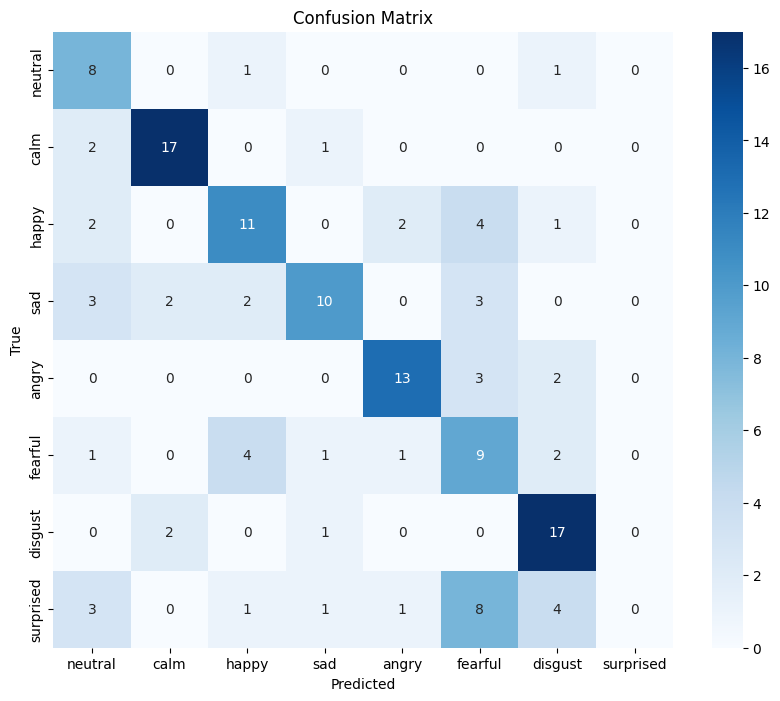

Classification Report:
              precision    recall  f1-score   support

     neutral       0.42      0.80      0.55        10
        calm       0.81      0.85      0.83        20
       happy       0.58      0.55      0.56        20
         sad       0.71      0.50      0.59        20
       angry       0.76      0.72      0.74        18
     fearful       0.33      0.50      0.40        18
     disgust       0.63      0.85      0.72        20
   surprised       0.00      0.00      0.00        18

    accuracy                           0.59       144
   macro avg       0.53      0.60      0.55       144
weighted avg       0.55      0.59      0.56       144



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



trained_new_model.eval()
device = 'mps'
all_preds = []
all_labels = []
with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        _, softmax_outputs = trained_new_model(X)
        predicted = torch.argmax(softmax_outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(Y.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=EMOTIONS_MAP.values(), yticklabels=EMOTIONS_MAP.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


class_report = classification_report(all_labels, all_preds, target_names=EMOTIONS_MAP.values(), zero_division=0)
print("Classification Report:")
print(class_report)

In [37]:
torch.save(trained_new_model.state_dict(),"model_59.pth")

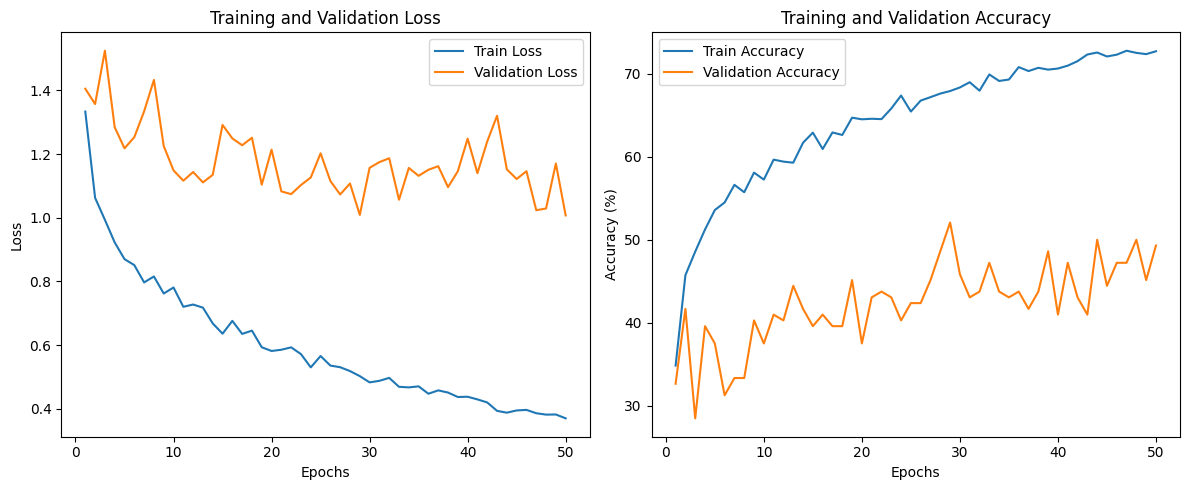

In [36]:
plot(new_train_losses, new_val_losses, new_train_accuracies, new_val_accuracies)